In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re

from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty, index_converter
from collections import defaultdict
import pickle
import math
from scipy.stats import linregress
import pingouin
import copy

plt.rcParams.update({'font.sans-serif': 'Helvetica'})  # consistent figure formatting

In [2]:
def hidden_linreg(target, ref, num_hide=3, num_reps=10):
    # Main evaluation function for a gel lane -
    # hides a number of bands, attempts to linear fit the remaining bands and then predicts the value of the unseen bands

    # Initialize an empty list to store the selected sets
    selected_sets = set()

    # Loop to select unique sets
    for _ in range(num_reps):
        # Select the first num_hide numbers as a set
        selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        # Check if the set is already selected
        while selected_set in selected_sets:
            selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        selected_sets.add(selected_set)

    errors = []
    full_errors = []
    full_no_abs_errors = []
    for combo in selected_sets:
        tfrac, rfrac = [t for ind, t in enumerate(target) if ind not in combo], [r for ind, r in enumerate(ref) if
                                                                                 ind not in combo]
        slope, intercept, r_value, p_value, std_err = linregress(tfrac, rfrac)
        pred_hidden = [slope * target[sel_ind] + intercept for sel_ind in combo]
        ref_hidden = [ref[sel_ind] for sel_ind in combo]
        percentage_errors = [(np.abs(t - p) / t) * 100 for t, p in zip(ref_hidden, pred_hidden)]
        perc_no_abs_errors = [((t - p) / t) * 100 for t, p in zip(ref_hidden, pred_hidden)]
        errors.append(np.average(percentage_errors))
        full_errors.extend(percentage_errors)
        full_no_abs_errors.extend(perc_no_abs_errors)
    return errors, full_errors, full_no_abs_errors, (slope, intercept, combo)


In [3]:
# Additional GG-direct data loaded here (mainly to get global + local background correction)
def load_gg_csv_files_to_dict(folder_path, prefix="prefix_"):
    """
    Load CSV files from a folder and create a dictionary of DataFrames with prefixed keys.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - prefix (str): The prefix to be added to the keys of the dictionary (default is "prefix_").

    Returns:
    - dataframes_dict (dict): A dictionary where keys are prefixed numbers, and values are corresponding DataFrames.
    """
    dataframes_dict = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            dataframe = pd.read_csv(file_path)

            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes_dict[key] = dataframe
    return dataframes_dict


def load_IS_csv_files_from_folders(parent_folder, prefix="IS_", bc_type='lane'):
    """
    Load CSV files from folders and create a dictionary of DataFrames with prefixed names.

    Parameters:
    - parent_folder (str): The path to the parent folder containing numbered subfolders.
    - prefix (str): The prefix to be added to the names of the DataFrames (default is "ga_").

    Returns:
    - dataframes (dict): A dictionary where keys are prefixed folder names, and values are corresponding DataFrames.
    """
    dataframes = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(parent_folder):
        # Check if the file is a CSV file
        if filename.endswith(".xls"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(parent_folder, filename)
            dataframe = pd.read_excel(file_path).drop(
                columns=['Image Name', 'Channel', 'Size', 'Area', 'Conc. Std.', 'Concentration'])
            dataframe.rename(columns={"Lane Name": "Lane ID",
                                      "Name": "Band ID",
                                      "Signal": "Image Studio (%s-BC)" % bc_type,
                                      "Total": "Image Studio (raw)"}, inplace=True)

            dataframe['Lane ID'] = dataframe['Lane ID'].str.extract(r'(\d+)').astype(int)
            dataframe['Band ID'] = dataframe['Band ID'].str.extract(r'(\d+)').astype(int)
            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes[key] = dataframe
    return dataframes


def load_ga_extra_csv_files_from_folders(parent_folder, prefix='gae_'):
    """
    Load CSV files from folders and create a dictionary of DataFrames with prefixed names.

    Parameters:
    - parent_folder (str): The path to the parent folder containing numbered subfolders.
    - prefix (str): The prefix to be added to the names of the DataFrames (default is "ga_").

    Returns:
    - dataframes (dict): A dictionary where keys are prefixed folder names, and values are corresponding DataFrames.
    """
    dataframes = {}  # Dictionary to store DataFrames

    # Iterate through folders in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # Check if the item in the parent folder is a directory
        if os.path.isdir(folder_path):
            csv_file_path = os.path.join(folder_path, "extra_background_data.csv")

            # Check if "collated_data_with_band_quality.csv" exists in the folder
            if os.path.isfile(csv_file_path):
                # Read the CSV file into a DataFrame
                dataframe = pd.read_csv(csv_file_path)
                dataframe = dataframe.rename(
                    columns={'Valley-to-Valley Volume': 'GA-V-Vol', 'Morphological Volume': 'GA-M-Vol'})

                # Add the prefix to the folder name and use it as the key in the dictionary
                prefixed_folder_name = f"{prefix}{folder_name}"
                dataframes[prefixed_folder_name] = dataframe

    return dataframes




In [4]:
# Datasets loaded in and combined here

# Main GG data + GA data here
data_pack = pickle.load(open(
    '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/combined_data_with_erosions_dilations_and_gelanalyzer.pkl',
    'rb'))
for key, val in data_pack.items():
    data_pack[key]['Rectangularity'] = data_pack[key]['Pixel Count'] / (
                data_pack[key]['Band Width'] * data_pack[key]['Band Height'])
non_data_cols = ['Lane ID', 'Band ID', 'Rectangularity', 'Band Height', 'Band Width', 'Pixel Count', 'Ref.',
                 'Pixel STD']

# IS data here
IS_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/image_studio/data_with_lane_background'
is_dfs = load_IS_csv_files_from_folders(IS_folder)

IS_median_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/image_studio/data_with_median_background'
is_median_dfs = load_IS_csv_files_from_folders(IS_median_folder, bc_type='median')

# extra GA data here
GA_extra_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/gelanalyzer'
ga_extra_dfs = load_ga_extra_csv_files_from_folders(GA_extra_folder)

# GG global/local data here
gg_path = Path(
    "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/qupath_data/james_data_v3_fixed_global/Data_with_norm_and_corrections")
gg_dfs = load_gg_csv_files_to_dict(gg_path, "gg_")  # loads data and converts to dictionary
gg_dfs = {key: gg_dfs[key] for key in sorted(gg_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in
                                                                           re.split(r'(\d+)', s)])}  # sorts by gel ID

# combines all data here
for key, val in data_pack.items():
    gg_df = gg_dfs['gg_%s' % key.split('_')[0]][
        ['Local Corrected Volume', 'Global Corrected Volume', 'Lane ID', 'Band ID']]
    data_pack[key] = pd.merge(val, gg_df, on=['Lane ID', 'Band ID'])

    is_df = is_dfs['IS_%s' % key.split('_')[0]]
    data_pack[key] = pd.merge(data_pack[key], is_df, on=['Lane ID', 'Band ID'])

    is_med_df = is_median_dfs['IS_%s' % key.split('_')[0]][['Image Studio (median-BC)', 'Lane ID', 'Band ID']]
    data_pack[key] = pd.merge(data_pack[key], is_med_df, on=['Lane ID', 'Band ID'])

    ga_extra_df = ga_extra_dfs['gae_%s' % key.split('_')[0]]
    data_pack[key] = pd.merge(data_pack[key], ga_extra_df, on=['Lane ID', 'Band ID'])


In [5]:
data_pack['33_NEB']

,Raw,RB Corrected,Lane ID,Band ID,Ref.,Pixel Count,Band Width,Band Height,Pixel Average,Pixel STD,...,GA-Raw-Vol,GA-BC-Vol,Rectangularity,Local Corrected Volume,Global Corrected Volume,Image Studio (lane-BC),Image Studio (raw),Image Studio (median-BC),GA-M-Vol,GA-V-Vol
0,36398,19484,10,1,40,286,51,7,127.265734,17.554093,...,1620,515,0.801120,11026.639148,20632.365199,13081.776627,95513,21563,592,268
1,43146,26864,9,1,40,260,52,6,165.946154,26.802070,...,2067,634,0.833333,20683.349727,28813.604726,27152.631378,77171,28045,646,495
2,57729,37458,6,1,40,295,52,8,195.691525,17.403577,...,2213,916,0.709135,28124.797808,41467.243824,36192.917557,103903,48107,959,689
3,45786,28319,7,1,40,262,52,7,174.755725,25.417459,...,1746,643,0.719780,23339.348485,31343.355532,31020.105652,83316,33900,643,570
4,46330,29013,8,1,40,267,52,7,173.520599,25.172412,...,1745,653,0.733516,23304.218551,31611.732546,31280.443115,83267,33851,648,569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,176498,101616,5,10,122,852,52,23,207.157277,5.521291,...,4942,1892,0.712375,45240.050251,129531.843179,15031.703796,244287,33747,2472,587
96,88084,46043,5,9,45,490,49,15,179.763265,11.286486,...,3107,1034,0.666667,13089.624365,61072.947368,8755.991394,183593,48395,1207,307
97,175518,101637,6,10,122,849,52,23,206.734982,6.119479,...,4578,1864,0.709866,48399.223058,128717.216971,26665.552673,250480,35706,2387,690
98,87790,44857,6,9,45,505,51,14,173.841584,12.838165,...,2755,954,0.707283,18549.181439,59952.078410,18318.877258,159936,44777,1099,352


In [6]:

# linear regression for dataset carried out here
# All data except lane 2 of 14,16,17 are considered (the lane was impacted by the high-temp gel running and bands cannot be accurately defined)
blind_pred_dict = defaultdict(list)
all_error_dict = defaultdict(list)
all_error_no_abs_dict = defaultdict(list)
descriptor_dict = defaultdict(list)
high_intensity = ['3_Thermo', '4_Thermo', '6_Thermo', '7_Thermo', '8_Thermo', '10_Thermo', '11_Thermo', '12_Thermo',
                  '17_NEB', '19_NEB', '20_NEB', '21_NEB', '24_NEB', '29_NEB', '31_NEB', '32_Thermo', '33_NEB']
low_intensity = ['0_Thermo', '1_Thermo', '2_Thermo', '5_Thermo', '9_Thermo', '13_NEB', '14_NEB', '15_NEB', '16_NEB',
                 '18_NEB', '22_NEB', '23_NEB', '34_Thermo']

np.random.seed(12)

for big_key in data_pack.keys():
    sel_df = copy.copy(data_pack[big_key])
    sel_df[sel_df < 0] = 0
    ladder_type = 'NEB'
    if 'Thermo' in big_key:
        ladder_type = 'ThermoFisher'
    for col_index, column in enumerate(sel_df.columns):
        if column in non_data_cols:
            continue
        if ' BC' in column and 'Raw' not in column:
            continue
        for lane in np.unique(sel_df['Lane ID']):

            if lane == 2 and big_key in ['14_NEB', '16_NEB', '17_NEB']:
                continue

            ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
            target = sel_df[sel_df['Lane ID'] == lane][column].to_numpy()
            errors, full_errors, full_no_abs_errors, (slope, intercept, combo) = hidden_linreg(target, ref, 5, 80)
            blind_pred_dict[column].append(np.average(errors))
            all_error_dict[column].extend(full_errors)
            all_error_no_abs_dict[column].extend(full_no_abs_errors)

            if column == 'Raw':  # adds one time data for each lane e.g. rectangularity level, etc.
                rectangularity_sum = np.sum(sel_df[sel_df['Lane ID'] == lane]['Rectangularity'].to_numpy()) / len(ref)
                descriptor_dict['Rectangularity'].append(rectangularity_sum)

                pixel_av = np.sum(sel_df[sel_df['Lane ID'] == lane]['Pixel Average'].to_numpy()) / len(ref)
                if pixel_av > 255:  # 16-bit norm
                    pixel_av = pixel_av / 65535
                else:  # 8-bit norm
                    pixel_av = pixel_av / 255

                descriptor_dict['Pixel Average'].append(pixel_av)
                descriptor_dict['Gel Name'].append(big_key)
                blind_pred_dict['Ladder'].append(ladder_type)
                blind_pred_dict['Gel'].append(big_key)

                all_error_no_abs_dict['Ladder'].extend([ladder_type] * len(full_no_abs_errors))

                if big_key in high_intensity:
                    descriptor_dict['Gel Intensity'].append('High')
                else:
                    descriptor_dict['Gel Intensity'].append('Low')

blind_df = pd.DataFrame.from_dict(blind_pred_dict)
blind_df_all = pd.DataFrame.from_dict(all_error_dict)  # this isn't necessary, but nice to have
blind_df_all_no_abs = pd.DataFrame.from_dict(all_error_no_abs_dict)
descriptor_df = pd.DataFrame.from_dict(descriptor_dict)

In [69]:
blind_df.describe()

,Raw,RB Corrected,Pixel Average,erosion 1,erosion 2,dilation 1,dilation 2,random adjustment 1,GA-Raw-Vol,GA-BC-Vol,Local Corrected Volume,Global Corrected Volume,Image Studio (lane-BC),Image Studio (raw),Image Studio (median-BC),GA-M-Vol,GA-V-Vol
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,22.401167,23.672995,36.281700,22.753080,24.250832,22.682700,23.026453,29.416014,25.243072,22.264921,28.638706,24.262723,27.567102,27.892268,27.380763,23.388229,26.238360
std,9.170696,9.015281,9.923980,8.213738,8.182655,9.628616,10.151122,7.750999,10.662223,10.305246,6.974070,9.039196,11.752202,10.499510,10.982622,9.697765,11.185609
min,8.831916,6.911887,17.474398,8.137094,9.527695,8.476274,7.509810,12.464224,6.564939,6.083439,16.351984,7.773872,8.669975,9.908553,8.194727,8.209287,6.681949
25%,14.265248,15.841095,29.982022,15.755554,17.290103,14.074334,13.631818,24.140768,15.508126,13.250486,23.566114,16.418684,19.862692,19.722433,19.885427,15.072187,17.171666
50%,20.572185,22.108907,34.705078,22.021967,23.286273,20.479016,19.823859,28.823105,25.757525,20.310711,28.035240,22.212568,26.848384,28.333320,26.592039,21.120282,25.911115
75%,29.115704,30.221776,39.925773,29.055774,30.641724,30.886991,32.889013,34.268517,33.954275,31.111725,32.332662,32.178286,34.010370,35.485837,35.203706,31.714750,33.216608
max,46.846122,41.128005,79.156909,49.107893,51.223090,45.278423,49.972852,74.673426,52.239884,40.771076,49.726162,46.729109,71.612584,55.977996,56.354890,43.509831,57.101943


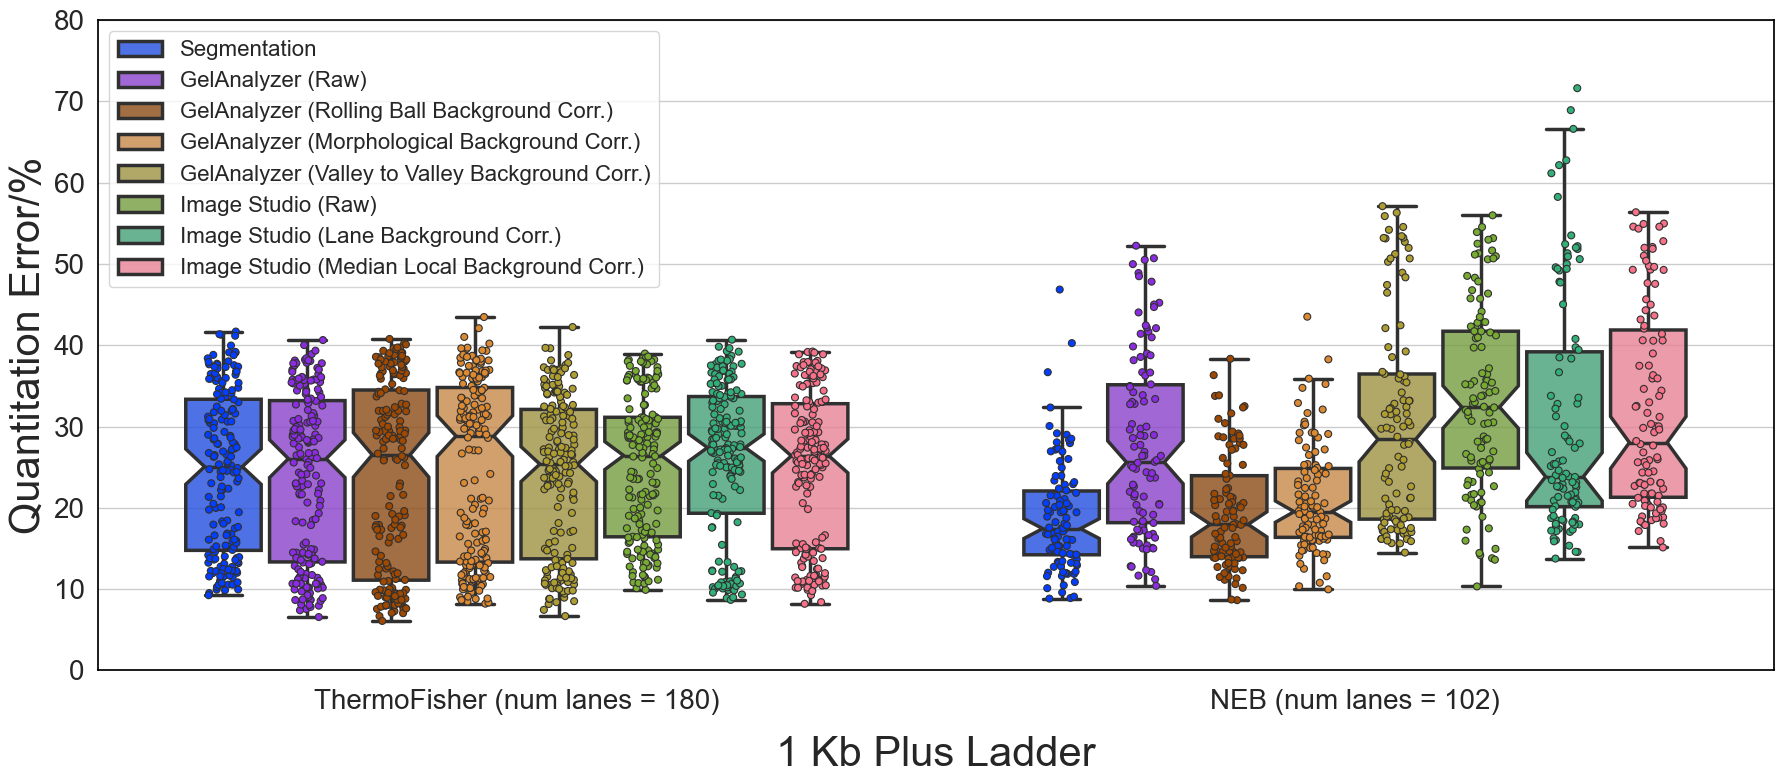

In [84]:
# generates a single large box plot comparing all of the new methods - image studio (raw, lane correction and median correction) and gelanalyzer (morphological and valley-to-valley correction)

df_adjusted = blind_df.drop(
    columns=['Pixel Average', 'RB Corrected', 'random adjustment 1', 'erosion 1', 'dilation 1', 'erosion 2',
             'dilation 2', 'Local Corrected Volume', 'Global Corrected Volume',
             'Gel'])

df_adjusted.rename(columns={"Raw": "Segmentation",
                            "GA-Raw-Vol": "GelAnalyzer (Raw)",
                            "GA-BC-Vol": "GelAnalyzer (Rolling Ball Background Corr.)",
                            "GA-M-Vol": "GelAnalyzer (Morphological Background Corr.)",
                            "GA-V-Vol": "GelAnalyzer (Valley to Valley Background Corr.)",
                            "Image Studio (raw)": "Image Studio (Raw)",
                            "Image Studio (lane-BC)": "Image Studio (Lane Background Corr.)",
                            "Image Studio (median-BC)": "Image Studio (Median Local Background Corr.)"}, inplace=True)

df_adjusted = df_adjusted[['Ladder', 'Segmentation', 'GelAnalyzer (Raw)', 'GelAnalyzer (Rolling Ball Background Corr.)',
                           'GelAnalyzer (Morphological Background Corr.)',
                           'GelAnalyzer (Valley to Valley Background Corr.)', 'Image Studio (Raw)',
                           'Image Studio (Lane Background Corr.)', 'Image Studio (Median Local Background Corr.)']]

df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(18, 8))

# sel_palette = "bright"
# sel_palette = ['#023eff', '#8b2be2', '#9f4800', '#f77189', '#ce9032', '#97a431' ,'#32b166', '#36ada4' ]
sel_palette = ['#023eff', '#8b2be2', '#9f4800', '#dc8932', '#ae9d31', '#77ab31', '#33b07a', '#f77189']

sns.set(style="whitegrid")

ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False,
                 notch=True, gap=.1, widths=[0.09, 0.09], palette=sel_palette, linewidth=2.5)

ax.tick_params(axis='x', labelsize=20, size=10)
ax.set_xticks(ax.get_xticks())  # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),
                    'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark")
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True,
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=30, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=30)
plt.yticks(fontsize=20)
plt.ylim([0, 80])
ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_multiple_methods.pdf')
pass

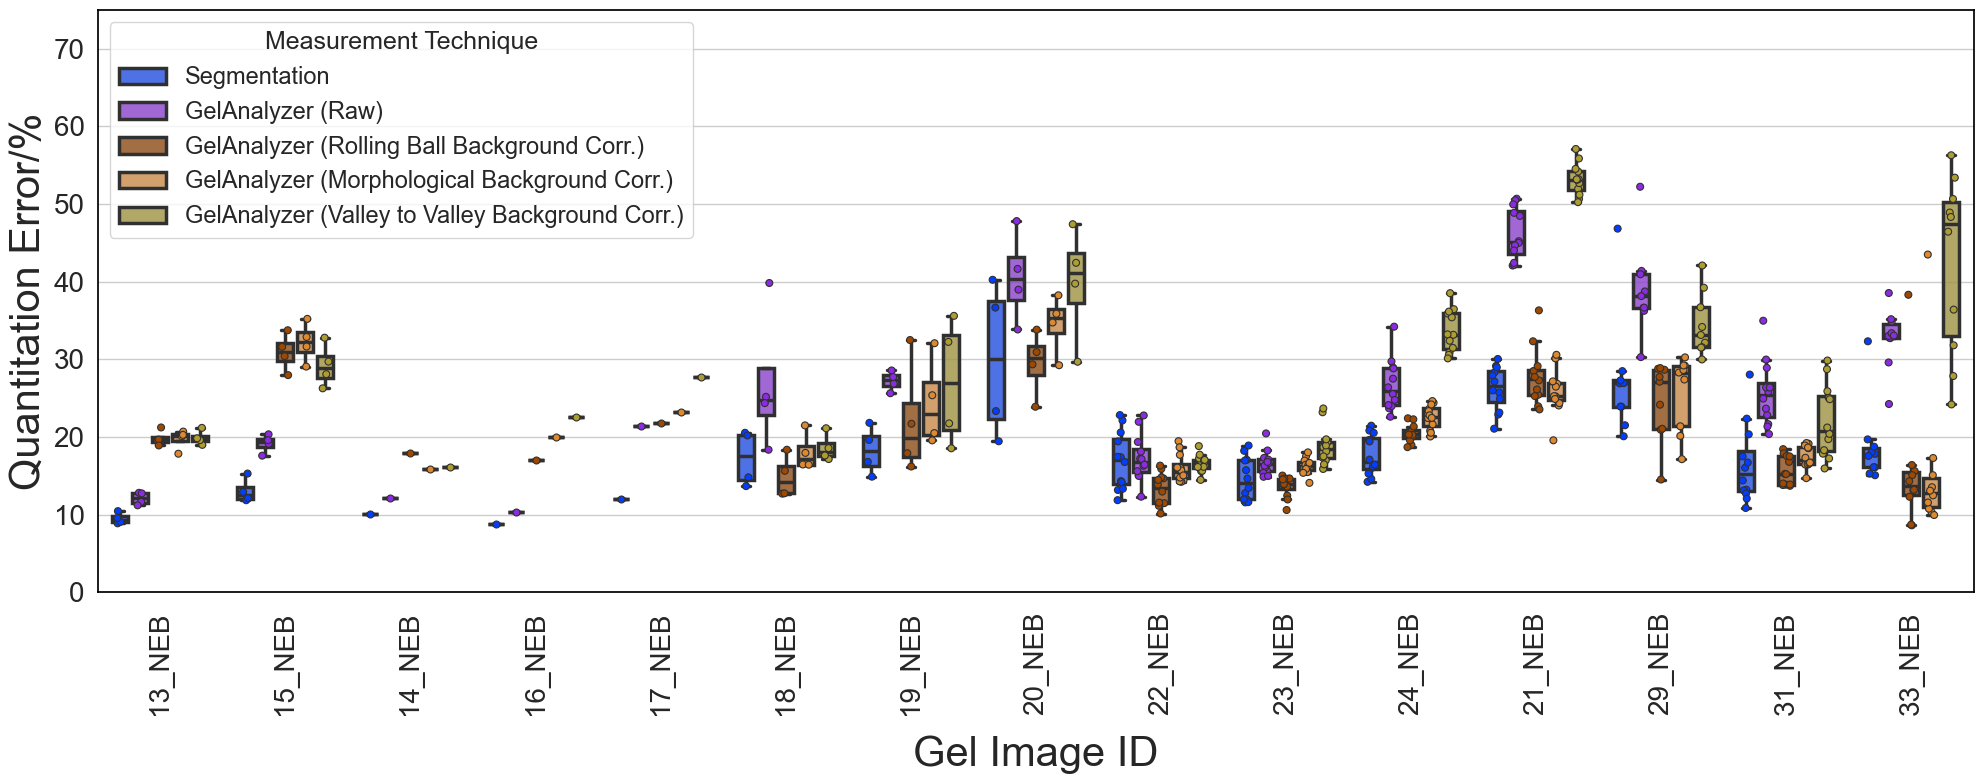

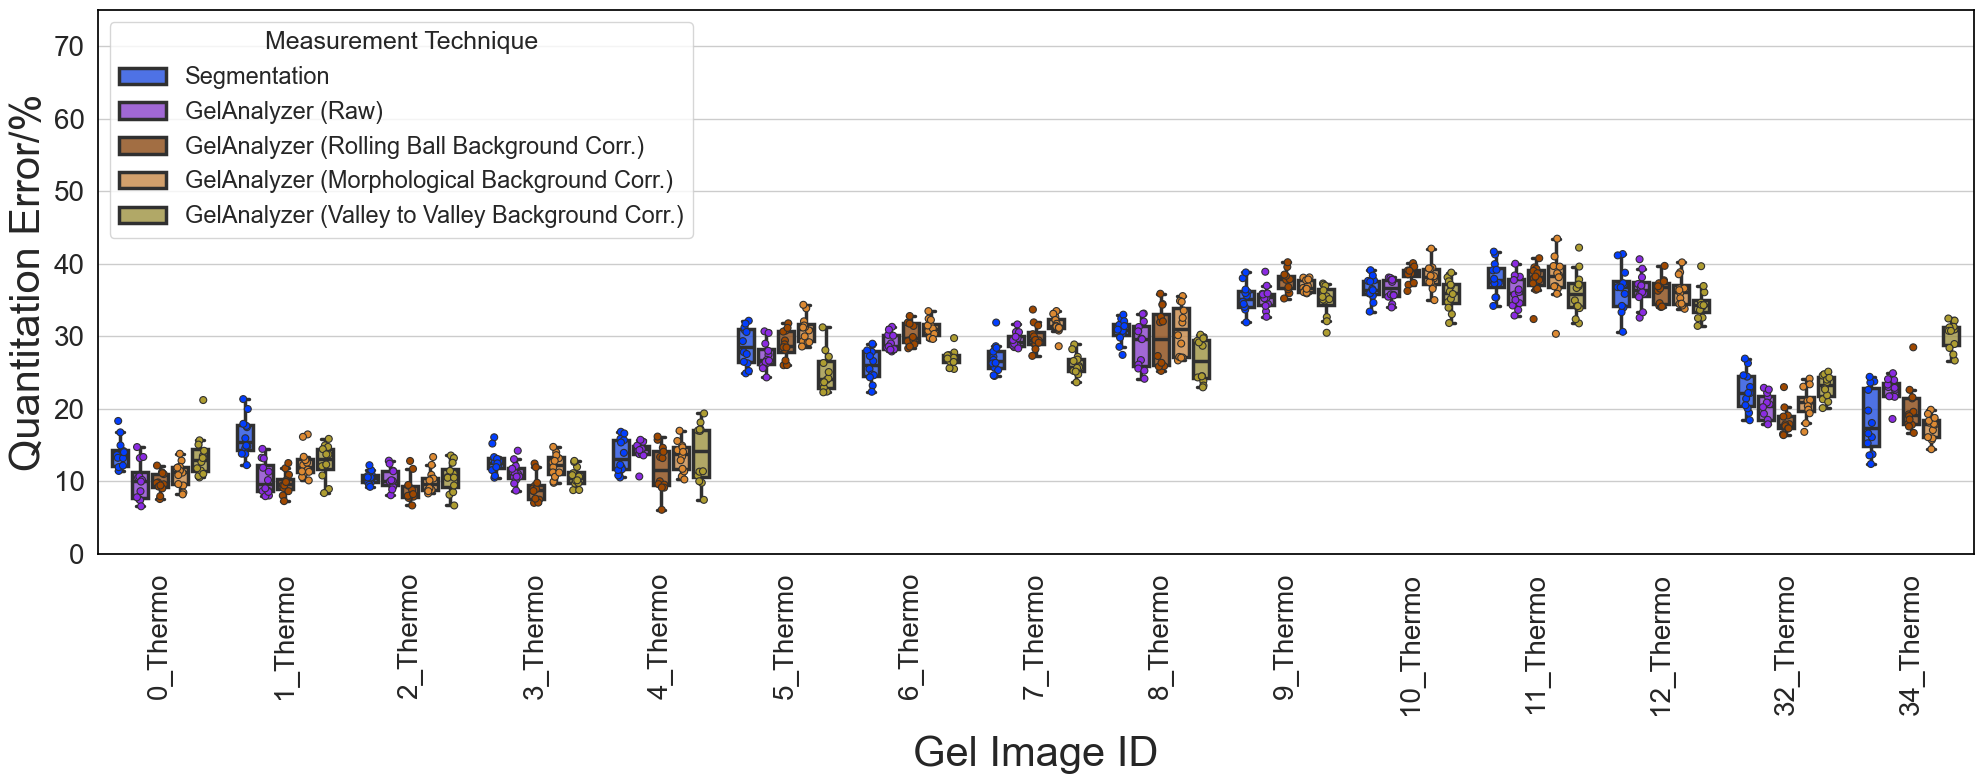

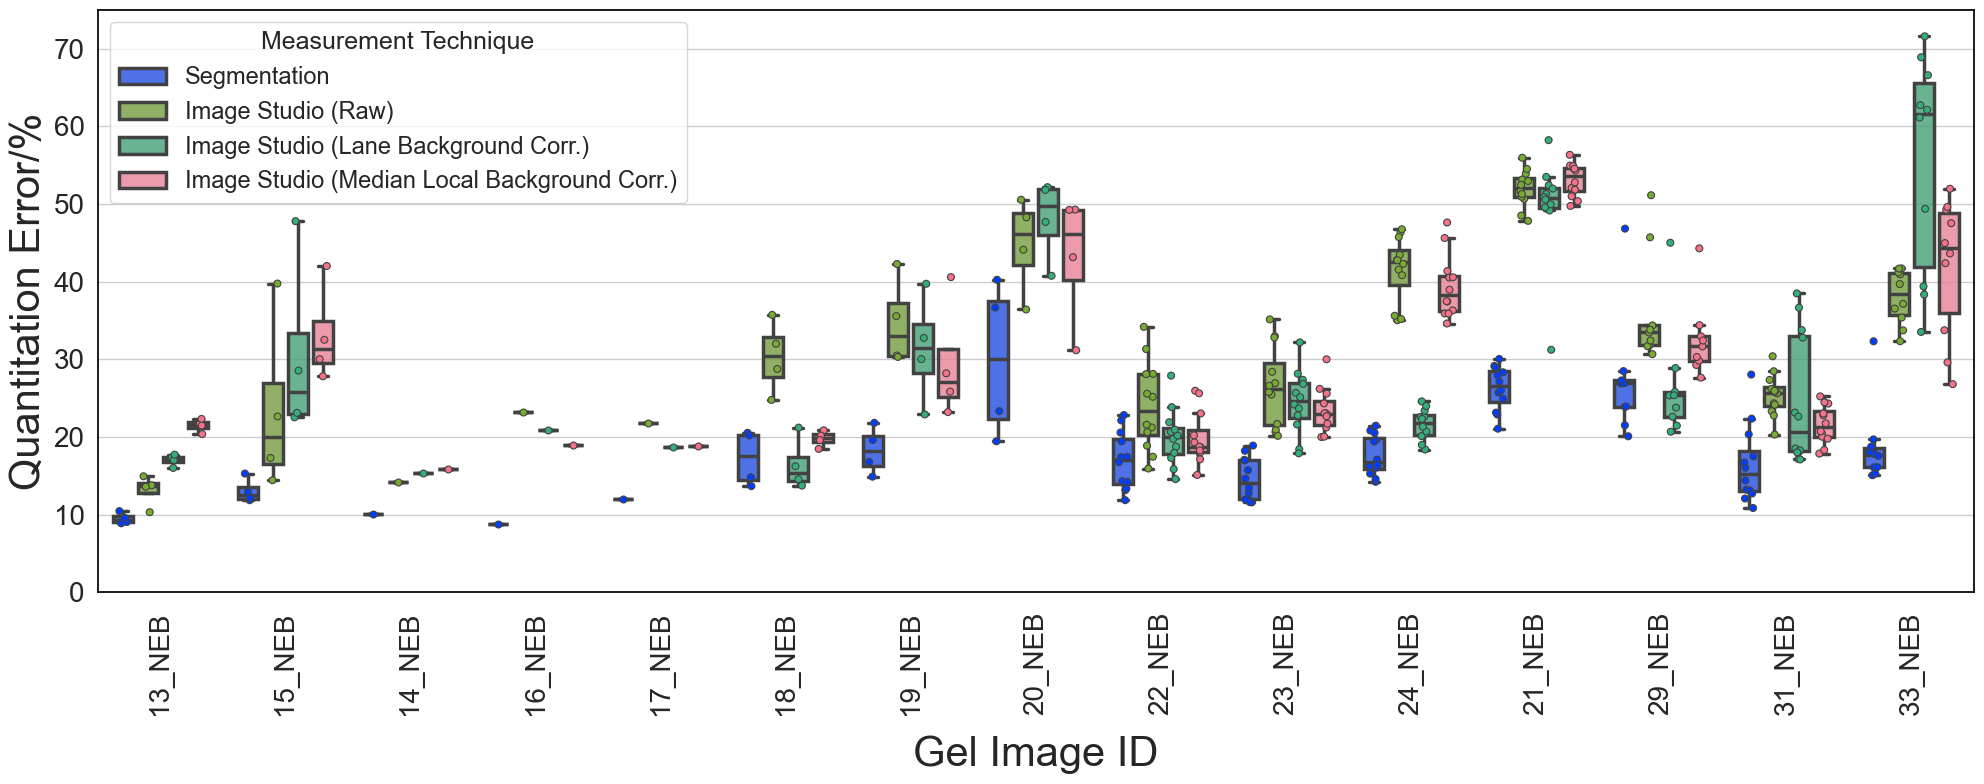

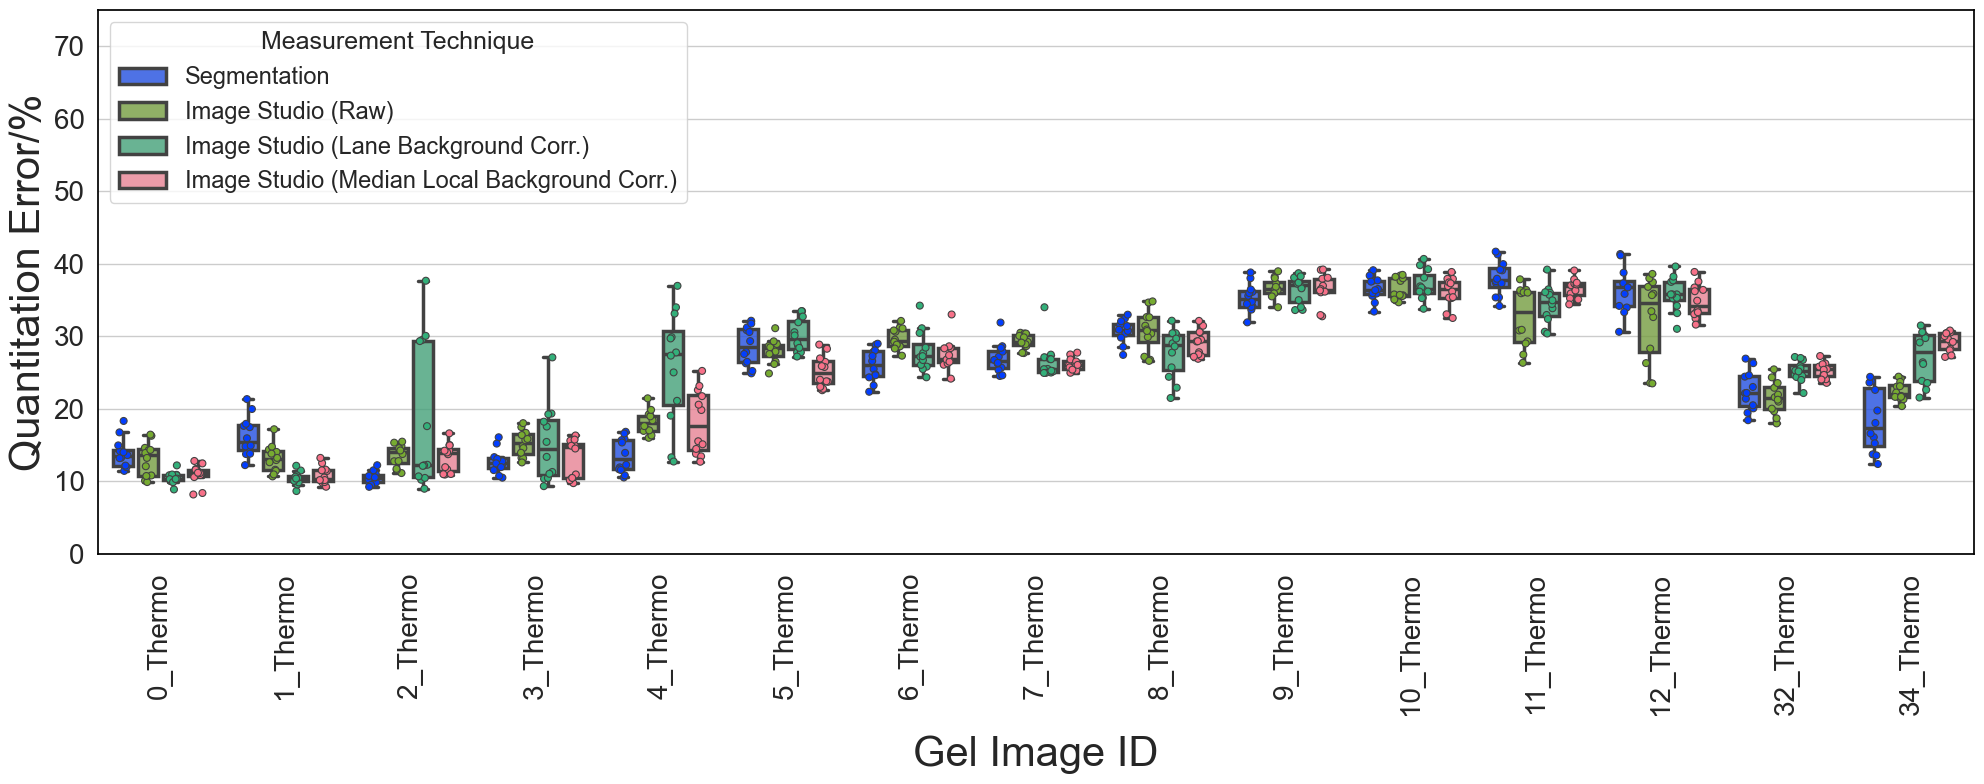

In [91]:

mix_1 = ['Gel', 'Segmentation', 'GelAnalyzer (Raw)', 'GelAnalyzer (Rolling Ball Background Corr.)',
         'GelAnalyzer (Morphological Background Corr.)', 'GelAnalyzer (Valley to Valley Background Corr.)']
mix_2 = ['Gel', 'Segmentation', 'Image Studio (Raw)', 'Image Studio (Lane Background Corr.)',
         'Image Studio (Median Local Background Corr.)']
palette_1 = ['#023eff', '#8b2be2', '#9f4800', '#dc8932', '#ae9d31']
palette_2 = ['#023eff', '#77ab31', '#33b07a', '#f77189']
names = ['GelAnalyzer', 'Image Studio']

for mix, palette, group_name in zip([mix_1, mix_2], [palette_1, palette_2], names):
    for l_target in ['NEB', 'ThermoFisher']:
        bdf = copy.copy(blind_df[blind_df['Ladder'] == l_target])

        bdf.rename(columns={"Raw": "Segmentation",
                            "GA-Raw-Vol": "GelAnalyzer (Raw)",
                            "GA-BC-Vol": "GelAnalyzer (Rolling Ball Background Corr.)",
                            "GA-M-Vol": "GelAnalyzer (Morphological Background Corr.)",
                            "GA-V-Vol": "GelAnalyzer (Valley to Valley Background Corr.)",
                            "Image Studio (raw)": "Image Studio (Raw)",
                            "Image Studio (lane-BC)": "Image Studio (Lane Background Corr.)",
                            "Image Studio (median-BC)": "Image Studio (Median Local Background Corr.)"}, inplace=True)

        if l_target == 'NEB':
            gel_based_order = ['13_NEB', '15_NEB', '14_NEB', '16_NEB', '17_NEB', '18_NEB', '19_NEB', '20_NEB', '22_NEB',
                               '23_NEB', '24_NEB', '21_NEB', '29_NEB', '31_NEB', '33_NEB']
            # Create a mapping from the custom order
            order_mapping = {val: idx for idx, val in enumerate(gel_based_order)}
            # Sort using the custom order
            bdf['Order'] = bdf['Gel'].map(order_mapping)
            bdf = bdf.sort_values(by='Order').drop(columns='Order').reset_index(drop=True)

        # for now, random adjustment and additional erosion/dilation are unnecessary.  Will add these to supp info.
        df_adjusted = bdf[mix]

        df_melted = pd.melt(df_adjusted, id_vars=['Gel'], var_name='Values')
        plt.figure(figsize=(20, 8))

        sns.set(style="whitegrid")
        # ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
        ax = sns.boxplot(x='Gel', y='value', hue='Values', data=df_melted, showfliers=False,
                         gap=.2, palette=palette, linewidth=2.5)
        ax.tick_params(axis='x', labelsize=20, size=10)
        ax.set_xticks(ax.get_xticks())  # just to silence annoying warning
        for patch in ax.patches:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .8))
        # sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark")
        sns.stripplot(x='Gel', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True,
                      alpha=1.0, marker="o", palette=palette, linewidth=0.8)

        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        # sns.despine(offset=10, trim=False)
        plt.xlabel('Gel Image ID', fontsize=30, labelpad=15)
        plt.ylabel('Quantitation Error/%', fontsize=30)
        plt.yticks(fontsize=20)
        plt.xticks(rotation=90)
        plt.ylim([0, 75])
        ax.legend(title='Measurement Technique', fontsize=17, title_fontsize=18, loc='upper left')
        plt.tight_layout()
        plt.savefig(f'/Users/matt/Desktop/gel_comp_seg_dataset_{group_name}_{l_target}.pdf')
        pass

In [112]:
# generates all data for big comparison table

df_adjusted = blind_df.drop(columns=['Pixel Average', 'random adjustment 1', 'Gel'])

df_adjusted.rename(columns={"Raw": "Segmentation",
                            "GA-Raw-Vol": "GelAnalyzer (Raw)",
                            "Local Corrected Volume": "Local Background Corrected Segmentation",
                            "Global Corrected Volume": "Patch (Global) Background Corrected Segmentation",
                            "GA-BC-Vol": "GelAnalyzer (Rolling Ball Background Corr.)",
                            "GA-M-Vol": "GelAnalyzer (Morphological Background Corr.)",
                            "GA-V-Vol": "GelAnalyzer (Valley to Valley Background Corr.)",
                            "Image Studio (raw)": "Image Studio (Raw)",
                            "Image Studio (lane-BC)": "Image Studio (Lane Background Corr.)",
                            "Image Studio (median-BC)": "Image Studio (Median Local Background Corr.)",
                            "RB Corrected": "Rolling Ball Background Corrected Segmentation",
                            "erosion 1": "1 Pixel Eroded Segmentation",
                            "dilation 1": "1 Pixel Dilated Segmentation",
                            "erosion 2": "2 Pixel Eroded Segmentation",
                            "dilation 2": "2 Pixel Dilated Segmentation"}, inplace=True)
df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Model')
# Group by 'Model' and 'Ladder' to compute mean and std
agg_df = df_melted.groupby(['Model', 'Ladder'])['value'].agg(['mean', 'std'])
# Reset the index for a clean table structure
agg_df = agg_df.reset_index()
# Pivot the table to get columns for each 'Ladder' with mean and std for each 'Model'
pivot_df = agg_df.pivot(index='Model', columns='Ladder', values=['mean', 'std'])
# Swap the levels of the MultiIndex columns
df_swapped = pivot_df.swaplevel('Ladder', None, axis=1).reindex(
    columns=[('ThermoFisher', 'mean'), ('ThermoFisher', 'std'), ('NEB', 'mean'), ('NEB', 'std')])

df_swapped = df_swapped.reindex(['Segmentation', 'Rolling Ball Background Corrected Segmentation',
                                 'Patch (Global) Background Corrected Segmentation',
                                 'Local Background Corrected Segmentation', '1 Pixel Eroded Segmentation',
                                 '2 Pixel Eroded Segmentation', '1 Pixel Dilated Segmentation',
                                 '2 Pixel Dilated Segmentation', 'GelAnalyzer (Raw)',
                                 'GelAnalyzer (Rolling Ball Background Corr.)',
                                 'GelAnalyzer (Morphological Background Corr.)',
                                 'GelAnalyzer (Valley to Valley Background Corr.)',
                                 'Image Studio (Raw)', 'Image Studio (Lane Background Corr.)',
                                 'Image Studio (Median Local Background Corr.)'])
df_swapped

Ladder                                           ThermoFisher             \
                                                         mean        std   
Model                                                                      
Segmentation                                        24.427759   9.732780   
Rolling Ball Background Corrected Segmentation      26.194805   9.431765   
Patch (Global) Background Corrected Segmentation    26.995287   8.875583   
Local Background Corrected Segmentation             29.185368   5.947436   
1 Pixel Eroded Segmentation                         23.219104   8.884873   
2 Pixel Eroded Segmentation                         21.929676   7.699138   
1 Pixel Dilated Segmentation                        24.960224  10.176996   
2 Pixel Dilated Segmentation                        24.968067  10.517589   
GelAnalyzer (Raw)                                   23.900018  10.268248   
GelAnalyzer (Rolling Ball Background Corr.)         23.803146  11.568975   
GelAnalyzer (Morphological Background Corr.)        24.742386  10.881539   
GelAnalyzer (Valley to Valley Background Corr.)     24.031451   9.531843   
Image Studio (Raw)                                  24.893722   8.685543   
Image Studio (Lane Background Corr.)                25.917211   9.401162   
Image Studio (Median Local Background Corr.)        24.880085   9.373666   

Ladder                                                  NEB             
                                                       mean        std  
Model                                                                   
Segmentation                                      18.824827   6.772513  
Rolling Ball Background Corrected Segmentation    19.222742   6.093368  
Patch (Global) Background Corrected Segmentation  19.440550   7.135814  
Local Background Corrected Segmentation           27.674010   8.435471  
1 Pixel Eroded Segmentation                       21.930686   6.835616  
2 Pixel Eroded Segmentation                       28.346991   7.394708  
1 Pixel Dilated Segmentation                      18.663538   6.987236  
2 Pixel Dilated Segmentation                      19.600077   8.489212  
GelAnalyzer (Raw)                                 27.613167  10.978857  
GelAnalyzer (Rolling Ball Background Corr.)       19.550407   6.826413  
GelAnalyzer (Morphological Background Corr.)      20.998538   6.539703  
GelAnalyzer (Valley to Valley Background Corr.)   30.132905  12.770294  
Image Studio (Raw)                                33.183820  11.344887  
Image Studio (Lane Background Corr.)              30.478675  14.635874  
Image Studio (Median Local Background Corr.)      31.793726  12.208472

In [114]:
# Highlight the highest and second-highest values
def highlight_latex(column):
    col = column.copy()
    max_idx = col.idxmin()  # Index of the highest value
    second_max_idx = col[col != col[max_idx]].idxmin()  # Second-highest value
    col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
    col[second_max_idx] = f"\\textcolor{{blue}}{{{col[second_max_idx]:.2f}}}"
    return col

# Apply formatting to all "mean" columns
highlighted_df = df_swapped.apply(lambda col: highlight_latex(col) if "mean" in col.name else col)

latex_table = highlighted_df.to_latex(escape=False, float_format="%.2f")
print(latex_table)


\begin{tabular}{llrlr}
\toprule
Ladder & \multicolumn{2}{r}{ThermoFisher} & \multicolumn{2}{r}{NEB} \\
 & mean & std & mean & std \\
Model &  &  &  &  \\
\midrule
Segmentation & 24.43 & 9.73 & \textcolor{blue}{18.82} & 6.77 \\
Rolling Ball Background Corrected Segmentation & 26.19 & 9.43 & 19.22 & 6.09 \\
Patch (Global) Background Corrected Segmentation & 27.00 & 8.88 & 19.44 & 7.14 \\
Local Background Corrected Segmentation & 29.19 & 5.95 & 27.67 & 8.44 \\
1 Pixel Eroded Segmentation & \textcolor{blue}{23.22} & 8.88 & 21.93 & 6.84 \\
2 Pixel Eroded Segmentation & \textcolor{red}{21.93} & 7.70 & 28.35 & 7.39 \\
1 Pixel Dilated Segmentation & 24.96 & 10.18 & \textcolor{red}{18.66} & 6.99 \\
2 Pixel Dilated Segmentation & 24.97 & 10.52 & 19.60 & 8.49 \\
GelAnalyzer (Raw) & 23.90 & 10.27 & 27.61 & 10.98 \\
GelAnalyzer (Rolling Ball Background Corr.) & 23.80 & 11.57 & 19.55 & 6.83 \\
GelAnalyzer (Morphological Background Corr.) & 24.74 & 10.88 & 21.00 & 6.54 \\
GelAnalyzer (Valley to Valle

/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_60015/848203524.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{21.93}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"
/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_60015/848203524.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{18.66}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  col[max_idx] = f"\\textcolor{{red}}{{{col[max_idx]:.2f}}}"


# Extra Transparent Graphics

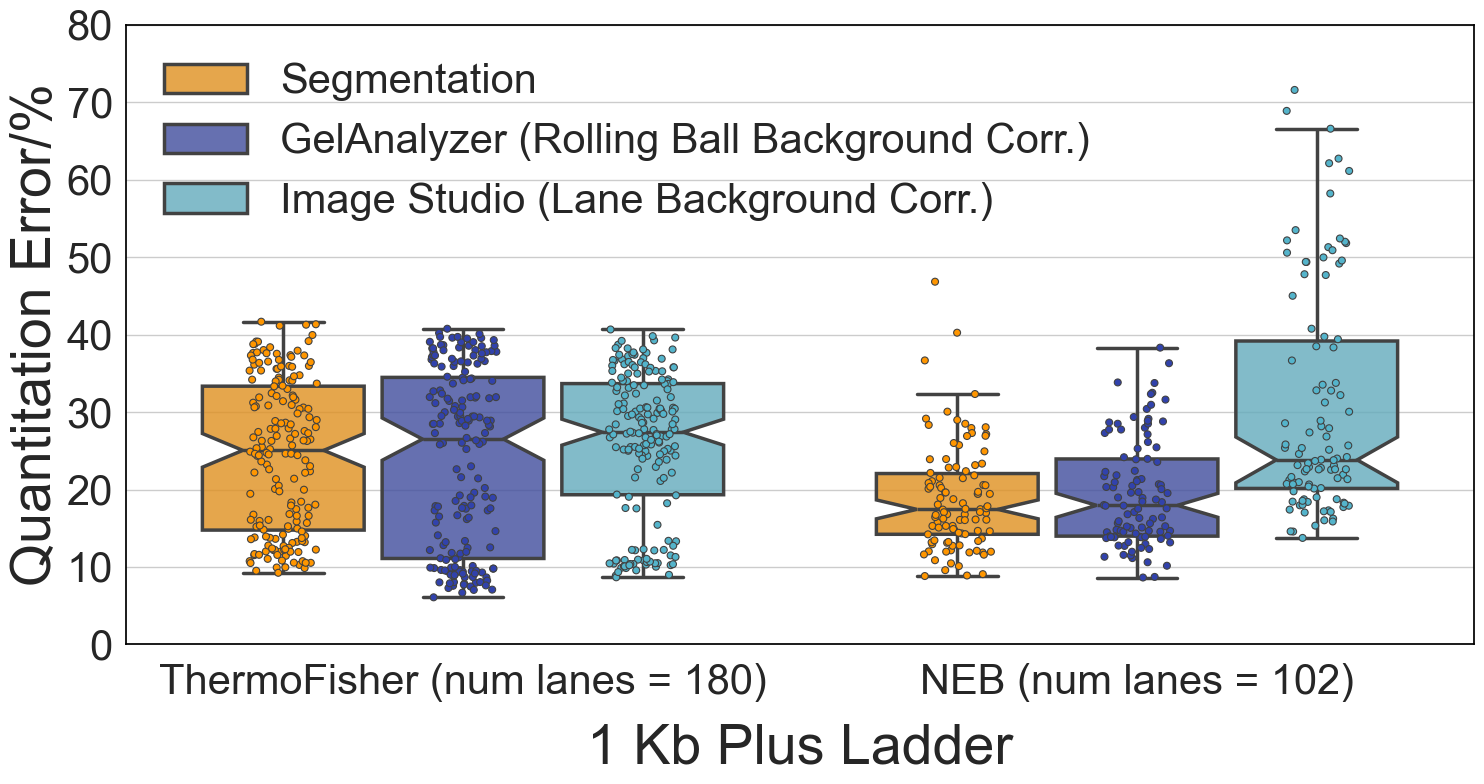

In [19]:

df_adjusted = blind_df.drop(
    columns=['Pixel Average', 'RB Corrected', 'random adjustment 1', 'erosion 1', 'dilation 1', 'erosion 2', 'GA-Raw-Vol', 'Image Studio (raw)', 'Image Studio (median-BC)', 'GA-M-Vol', 'GA-V-Vol',
             'dilation 2', 'Local Corrected Volume', 'Global Corrected Volume',
             'Gel'])

df_adjusted.rename(columns={"Raw": "Segmentation",
                            "GA-BC-Vol": "GelAnalyzer (Rolling Ball Background Corr.)",
                            "Image Studio (lane-BC)": "Image Studio (Lane Background Corr.)"}, inplace=True)

df_adjusted = df_adjusted[['Ladder', 'Segmentation', 'GelAnalyzer (Rolling Ball Background Corr.)',
                           'Image Studio (Lane Background Corr.)']]

df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
fig, m_ax = plt.subplots(figsize=(15, 8))

# sel_palette = "bright"
# sel_palette = ['#023eff', '#8b2be2', '#9f4800', '#f77189', '#ce9032', '#97a431' ,'#32b166', '#36ada4' ]
sel_palette = ['#FF9600', '#3142AC', '#54B4CB']

sns.set(style="whitegrid")

ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False,
                 notch=True, gap=.1, palette=sel_palette, linewidth=2.5)

ax.tick_params(axis='x', labelsize=30, size=10)
ax.set_xticks(ax.get_xticks())  # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),
                    'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark")
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True,
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8)

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=40, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=40)
plt.yticks(fontsize=30)
plt.ylim([0, 80])
legend = ax.legend(fontsize=30)
legend.get_frame().set_alpha(0)
fig.patch.set_alpha(0)
m_ax.patch.set_alpha(0)
ax.set_facecolor((0, 0, 0, 0))  # Transparent background
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_multiple_methods.png', dpi=300)
pass

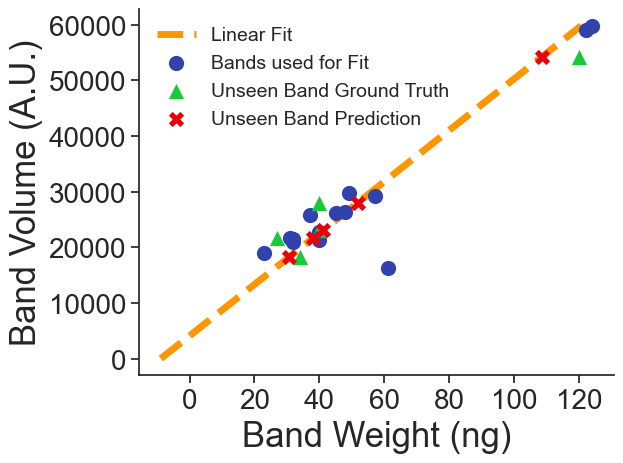

In [41]:
sel_df = data_pack['23_NEB']
lane = 2
ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
target = sel_df[sel_df['Lane ID'] == lane]['Raw'].to_numpy()
np.random.seed(12)
sns.set(style="ticks")

for lane in [4]:
    for i in range(10):
        selected_sets = set()
        num_hide = 5

        # Select the first num_hide numbers as a set
        selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        # Check if the set is already selected
        while selected_set in selected_sets:
            selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        selected_sets.add(selected_set)
        combo = next(iter(selected_sets))

        tfrac, rfrac = [t for ind, t in enumerate(target) if ind not in combo], [r for ind, r in enumerate(ref) if ind not in combo]
        linreg_result = linregress(tfrac, rfrac)
        slope = linreg_result.slope
        intercept = linreg_result.intercept

        pred_hidden = [slope * target[sel_ind] + intercept for sel_ind in combo]
        ref_hidden = [ref[sel_ind] for sel_ind in combo]
        target_hidden = [target[sel_ind] for sel_ind in combo]
        fig, ax = plt.subplots()

        y_data = range(0,int(np.max(target)))
        x_data = slope*y_data + intercept

        sns.lineplot(x=x_data, y=y_data,
                     linestyle='dashed', c='#FF9600', label='Linear Fit', linewidth=5, zorder=5)

        plt.scatter(rfrac, tfrac, c='#3142AC', label='Bands used for Fit',edgecolors='black', linewidth=0, zorder=6, s=120)
        plt.scatter(ref_hidden, target_hidden,c='#1ac938', label='Unseen Band Ground Truth',edgecolors='black',
                    linewidth=0, zorder=7, s=120, marker='^')
        plt.scatter(pred_hidden, target_hidden, c='#e8000b', label='Unseen Band Prediction',edgecolors='black',
                    linewidth=0, marker='X', zorder=8, s=120)


        # sns.regplot(x=rfrac, y=tfrac)
        legend = plt.legend(fontsize=14, loc ='upper left')

        plt.xlabel('Band Weight (ng)', fontsize=25)
        plt.ylabel('Band Volume (A.U.)', fontsize=25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)

        legend.get_frame().set_alpha(0)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
        ax.set_facecolor((0, 0, 0, 0))

        plt.tight_layout()
        if i == 8:
            plt.savefig('/Users/matt/Desktop/%s_%s.png' % (lane, i), dpi=300)
            plt.show()
        plt.close()

    break